In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import helper
import os
import time
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms ,models
from torch import optim
from torch.autograd import Variable
from PIL import Image

In [2]:
from torchvision import datasets, transforms
data_transforms = transforms.Compose([  #transforms.Resize(255),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
                   



trainset =  datasets.ImageFolder ('C:\\Users\\artip\\Downloads\\PetImages\\training_set\\training_set\\', transform = data_transforms )
trainloader = torch.utils.data.DataLoader(trainset , batch_size = 64 , shuffle = True)

testset =  datasets.ImageFolder ('C:\\Users\\artip\\Downloads\\PetImages\\test_set\\test_set\\', transform = data_transforms )
testloader = torch.utils.data.DataLoader(testset , batch_size = 64 , shuffle = True)


<class 'torch.Tensor'>
torch.Size([64, 3, 224, 224])


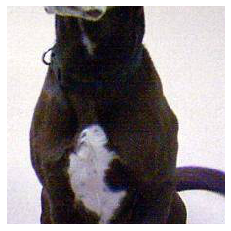

In [3]:
images,labels  = next(iter(trainloader))
helper.imshow(images[0], normalize = False)
print(type(images))
print(images.shape)

In [4]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda')

In [6]:

model = models.resnet50(pretrained = True )

for param in model.parameters():
    param.requires_grad = False
    
classifier = nn.Sequential(
                     nn.Linear(2048,512),
                     #nn.ReLU(),
                     nn.Dropout(p = 0.2),
                     nn.ReLU(),
                     nn.Linear(512,2),
                     nn.LogSoftmax(dim = 1)
)

model.fc = classifier


criterion = nn.NLLLoss()
optimizer = optim.SGD(model.fc.parameters(), lr = 0.003)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:

 
epochs = 5
steps = 0
train_losses, test_losses = [] , []
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten the Image from 28*28 to 784 column vector
        #images , labels = images.to(device), labels.to(device)
        
        images , labels = images.to(device), labels.to(device)
        
        # setting gradient to zeros
        optimizer.zero_grad()        
        output = model(images)
        loss = criterion(output, labels)
        
        # backward propagation
        loss.backward()
        
        # update the gradient to new gradients
        optimizer.step()
        running_loss += loss.item()
        
    else:
        test_loss = 0
        acc = 0
        with torch.no_grad():
            model.eval()
            
            for images,labels in testloader:
            
                images , labels = images.to(device), labels.to(device)
                output = model(images)
                test_loss += criterion(output,labels)
                
                ps = torch.exp(output)
                top_p,top_class = ps.topk(1,dim=1)
                equals = top_class == labels.view(*top_class.shape)
                acc += torch.mean(equals.type(torch.FloatTensor))
                
                
        #model.train()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
                
            print(f"Epoch: {epoch+1} / {epochs} .... " ,
                      f"train_loss : {running_loss/len(trainloader):.3f}... ",
                      f"test_loss : {test_loss/len(testloader):.3f}.... ",
                     f"test_acc : {acc/len(testloader):.3f}... "
             )
                
        #model.train()


Epoch: 1 / 5 ....  train_loss : 0.491...  test_loss : 0.332....  test_acc : 0.961... 
Epoch: 2 / 5 ....  train_loss : 0.253...  test_loss : 0.199....  test_acc : 0.963... 
Epoch: 3 / 5 ....  train_loss : 0.172...  test_loss : 0.148....  test_acc : 0.970... 
Epoch: 4 / 5 ....  train_loss : 0.136...  test_loss : 0.125....  test_acc : 0.971... 
Epoch: 5 / 5 ....  train_loss : 0.117...  test_loss : 0.110....  test_acc : 0.974... 


In [8]:
def view_classify(ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.cpu().numpy().squeeze()

    fig, ax2 = plt.subplots(figsize=(6,9))
    ax2.barh(np.arange(2), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(2))
    ax2.set_yticklabels([
                            'Cat',
                            'Dog'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [9]:
def imshow(image, ax=None, title=None, normalize=False):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


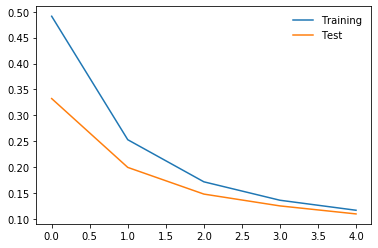

In [10]:
plt.plot(train_losses, label = 'Training')
plt.plot(test_losses, label = 'Test')
plt.legend(frameon = False)

tensor([[0.1102, 0.8898]], device='cuda:0')


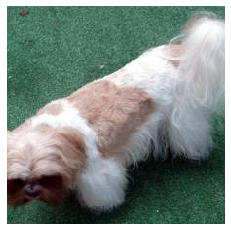

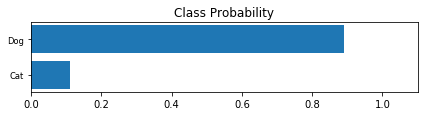

In [12]:
images, labels = next(iter(trainloader))
a1 = imshow(images[0])
images, labels = images.to(device), labels.to(device)
img = images[0].view(1,3,224,224)

with torch.no_grad():
    model = model.cuda()
    logits = model(img)
    
ps = torch.exp(logits)
print(ps)
view_classify(ps)
